In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.size'] = 20.0

from scipy.integrate import simps, cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import iqr

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import perturbations as PB
import dirs

In [4]:
M_min = 3.3e-19
M_max = 5.1e-5
def dNdM(Mlist, gamma=1.7):
    return ((1-gamma)*Mlist**(-gamma))/(M_max**(1-gamma)-M_min**(1-gamma))

#### AMC properties

Looking at histograms of $M_\mathrm{MC}$, $R_\mathrm{MC}$ and $\rho_{\mathrm{MC}}$...

In [14]:
#Specify the radius you'd like to investigate (in pc)
#Rstr = "6.96"
Rstr = "2.13"

In [15]:
#Load properties from the Monte Carlo results file
M_i, R_i, D_i, M_f, R_f, D_f, e, psi  = np.loadtxt(dirs.montecarlo_dir + "AMC_logflat_a=" + Rstr + "_NFW_circ.txt", unpack=True, delimiter=',')
V_i = (4/3)*np.pi*R_i**3
V_f = (4/3)*np.pi*R_f**3
rho_i = M_i/V_i
rho_f = M_f/V_f

Survival probability: 0.86884


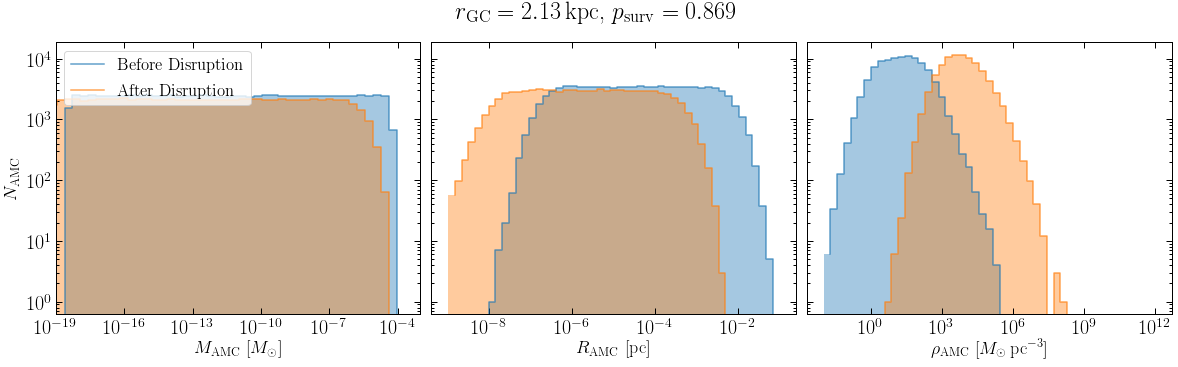

In [16]:
N_i = np.sum([M_i > 1e-21])
N_f = np.sum([M_f > 1e-21])

p_surv = N_f/N_i
print("Survival probability:", p_surv)
a_plot = 0.7
a_hist = 0.4

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,5), gridspec_kw={'wspace': 0.03})
fig.suptitle(r"$r_\mathrm{GC} = " + Rstr + "\,\mathrm{kpc}$, $p_\mathrm{surv} = %.3f$"%(p_surv,))


# Plot one
# M_bins = np.geomspace(1e-20, 1e-5, 50)
# plt.figure(figsize=(7,5))
counts, edges, patches = ax1.hist(M_i, bins=np.geomspace(1e-20, 1e-3, 50), alpha=a_hist)
ax1.step(edges[1:], counts, color='C0', alpha=a_plot, label='Before Disruption')
counts, edges, patches = ax1.hist(M_f, bins=np.geomspace(1e-20, 1e-3, 50), alpha=a_hist)
ax1.step(edges[1:], counts, color='C1', alpha=a_plot, label='After Disruption')

# ax1.hist(M_i, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='Before Disruption')
# ax1.hist(M_f, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='After Disruption')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$M_\mathrm{AMC}$ $[M_\odot]$")
ax1.set_ylabel(r"$N_\mathrm{AMC}$")
ax1.set_xlim(1e-19, 1e-3)

ax1.legend(loc='upper left')

# Plot two
counts, edges, patches = ax2.hist(R_i, bins=np.geomspace(1e-9, 1e-1, 50), alpha=a_hist)
ax2.step(edges[1:], counts, color='C0', alpha=a_plot)
counts, edges, patches = ax2.hist(R_f, bins=np.geomspace(1e-9, 1e-1, 50), alpha=a_hist)
ax2.step(edges[1:], counts, color='C1', alpha=a_plot)

# ax2.hist(R_i, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))
# ax2.hist(R_f, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$R_\mathrm{AMC}$ $[\mathrm{pc}]$")
# ax2.set_xlim(1e-9, 1e-3)
# plt.ylabel("$N_\mathrm{AMC}$")


# Plot three
counts, edges, patches = ax3.hist(rho_i, bins=np.geomspace(1e-2, 1e12, 50), alpha=a_hist)
ax3.step(edges[1:], counts, color='C0', alpha=a_plot)
counts, edges, patches = ax3.hist(rho_f, bins=np.geomspace(1e-2, 1e12, 50), alpha=a_hist)
ax3.step(edges[1:], counts, color='C1', alpha=a_plot)

# ax3.hist(rho_i, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))
# ax3.hist(rho_f, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))

ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r"$\rho_\mathrm{AMC}$ $[M_\odot\,\mathrm{pc}^{-3}]$")
# ax3.set_xlim(1e4, 1e10)
plt.show()

#plt.savefig("../plots/Distributions_PL_r="+Rstr+"kpc.pdf", bbox_inches='tight')

In [17]:
#### Plot the distributions P(X), for the mass, radius and density

In [ ]:
M_f_true, P_M_f_true = np.loadtxt(dirs.dists_dir + "distribution_mass_" + Rstr + "_NFW_circ.txt", unpack=True, delimiter=',')
R_f_true, P_R_f_true = np.loadtxt(dirs.dists_dir + "distribution_radius_" + Rstr + "_NFW_circ.txt", unpack=True, delimiter=',', usecols=(0,1))
R_i_true, P_R_i_true = np.loadtxt(dirs.dists_dir + "distribution_radius_NFW_circ_unperturbed.txt", unpack=True, delimiter=',', usecols=(0,1))

Mlist = np.geomspace(3.28433664535169e-19, 5.113402976492e-05, 100)

V_i = (4/3)*np.pi*R_i**3
V_f = (4/3)*np.pi*R_f**3
rho_i = M_i/V_i
rho_f = M_f/V_f


N_i = np.sum([M_i > 1e-21])
N_f = np.sum([M_f > 1e-21])

p_surv = N_f/N_i
print("Survival probability:", p_surv)
a_plot = 0.7
a_hist = 0.4
xpad=8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20,5), gridspec_kw={'wspace': 0.25})
# fig.suptitle(r"$r_\mathrm{GC} = " + Rstr + "\,\mathrm{kpc}$, $p_\mathrm{surv} = %.3f$"%(p_surv,))


# Plot one
# M_bins = np.geomspace(1e-20, 1e-5, 50)
# plt.figure(figsize=(7,5))
# print(M_i.min(), M_f.min())
# Mbins = np.geomspace(M_i.min(), M_i.max(), 50)
# print(M_i.min(), M_i.max())
# logwidth = np.diff(np.log10(Mbins))[0]
# Mbins = np.append(Mbins, Mbins[-1]*(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))

cbefore = 'k'
cafter = 'C8'


# counts, edges, patches = ax1.hist(M_i, bins=Mbins, alpha=a_hist, label='Before Disruption', density=True)
# ax1.step(edges[1:], counts, color='C0', alpha=a_plot)
# counts, edges, patches = ax1.hist(M_f, bins=Mbins, alpha=a_hist, label='After Disruption', density=True)
# ax1.step(edges[1:], counts, color='C1', alpha=a_plot)
#/(M_f_true[P_M_f_true>0.0]*P_M_f_true[P_M_f_true>0.0]).max()
ax1.plot(M_f_true[P_M_f_true>1e-30], M_f_true[P_M_f_true>1e-30]*P_M_f_true[P_M_f_true>1e-30], color=cafter)
ax1.plot(Mlist, Mlist*dNdM(Mlist), ls='--', color=cbefore)
print(np.trapz(dNdM(Mlist), x=Mlist))


# ax1.hist(M_i, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='Before Disruption')
# ax1.hist(M_f, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='After Disruption')


ax1.text(1e-19, 1e-11, r"$r_\mathrm{GC} = " + Rstr + "\,\mathrm{kpc}$, $p_\mathrm{surv} = %.3f$"%(p_surv,))
ax1.xaxis.set_tick_params(pad=xpad)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$M_\mathrm{AMC}$ $[M_\odot]$")
# ax1.set_ylabel(r"$N_\mathrm{AMC}$")
ax1.set_ylabel(r"$M_\mathrm{AMC} \times P(M_\mathrm{AMC})$")
ax1.set_xlim(1e-20, 1e-4)
ax1.set_ylim(1e-12, 10)




# Plot two
# counts, edges, patches = ax2.hist(R_i, bins=np.geomspace(1e-8, 1e0, 50), alpha=a_hist, density=True)
# ax2.step(edges[1:], counts, color='C0', alpha=a_plot)
# counts, edges, patches = ax2.hist(R_f, bins=np.geomspace(1e-8, 1e0, 50), alpha=a_hist, density=True)
# ax2.step(edges[1:], counts, color='C1', alpha=a_plot)
# ax2.plot(R_f_true[P_R_f_true>0.0], P_R_f_true[P_R_f_true>0.0], label='After Disruption', ls='--')
ax2.plot(R_f_true[P_R_f_true>1e-30], R_f_true[P_R_f_true>1e-30]*P_R_f_true[P_R_f_true>1e-30], color=cafter)
ax2.plot(R_i_true[P_R_i_true>1e-30], R_i_true[P_R_i_true>1e-30]*P_R_i_true[P_R_i_true>1e-30], ls='--', color=cbefore)

# ax2.hist(R_i, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))
# ax2.hist(R_f, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))

ax2.xaxis.set_tick_params(pad=xpad)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$R_\mathrm{AMC}$ $[\mathrm{pc}]$")
ax2.set_ylabel(r"$R_\mathrm{AMC} \times P(R_\mathrm{AMC})$")
ax2.plot([0], [0], ls='--', label='Unperturbed AMCs', color=cbefore)
ax2.plot([0], [0], label='Perturbed AMCs (NFW)', color=cafter)
ax2.legend(loc='lower left')
ax2.set_ylim(1e-15, 10)

# ax2.set_xlim(1e-9, 1e-3)
# plt.ylabel("$N_\mathrm{AMC}$")

# Plot three
# counts, edges, patches = ax3.hist(rho_i, bins=np.geomspace(1e-4, 1e6, 50), alpha=a_hist, density=True)
# ax3.step(edges[1:], counts, color='C0', alpha=a_plot)
# counts, edges, patches = ax3.hist(rho_f, bins=np.geomspace(1e-4, 1e6, 50), alpha=a_hist, density=True)
# ax3.step(edges[1:], counts, color='C1', alpha=a_plot)

counts, edges = np.histogram(rho_f, bins=np.geomspace(1e-4, 1e6, 50), density=True)
b_c = edges[:-1] + np.diff(edges)/2
ax3.plot(b_c[counts>0], b_c[counts>0]*counts[counts>0], color=cafter)
counts, edges = np.histogram(rho_i, bins=np.geomspace(1e-4, 1e6, 50), density=True)
b_c = edges[:-1] + np.diff(edges)/2
ax3.plot(b_c[counts>0], b_c[counts>0]*counts[counts>0], color=cbefore, ls='--')

# ax3.hist(rho_i, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))
# ax3.hist(rho_f, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))

ax3.xaxis.set_tick_params(pad=xpad)
ax3.yaxis.set_tick_params(pad=6)
ax3.set_ylabel(r"$\bar{\rho} \times P(\bar{\rho} )$")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r"$\bar{\rho}$ $[M_\odot\,\mathrm{pc}^{-3}]$")
ax3.set_ylim(1e-5, 0.9)

plt.savefig("../../plots/Distributions_NFW_r="+Rstr+"kpc.pdf", bbox_inches='tight')

Survival probability: 0.86884
1.0455032892876344
